# Logistic Regression - Assignment 6

In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from imblearn.over_sampling import SMOTE

In [157]:
!pip install imblearn  

Step 1 - Importing and Reading the dataset

In [158]:
bank_data = pd.read_csv('bank-full.csv', sep = ";")
bank_data = bank_data.dropna()
print(bank_data.shape)
print(list(bank_data.columns))

(45211, 17)
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


In [159]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [160]:
bank_data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


The dimention of bank data set is 45211 rows and 17 columns to be observed.

   # Input variables:
  
  # bank client data:
   
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   
   5 - default: has credit in default? (binary: "yes","no")
   
   6 - balance: average yearly balance, in euros (numeric) 
   
   7 - housing: has housing loan? (binary: "yes","no")
   
   8 - loan: has personal loan? (binary: "yes","no")
   
   # related with the last contact of the current campaign:
  
  9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  
  10 - day: last contact day of the month (numeric)
  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12 - duration: last contact duration, in seconds (numeric)
   
   # other attributes:
  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
 
 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable -> y
y -> Whether the client has subscribed a term deposit or not Binomial ("yes" or "no")


# Data Transformation

In [109]:
bank_data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

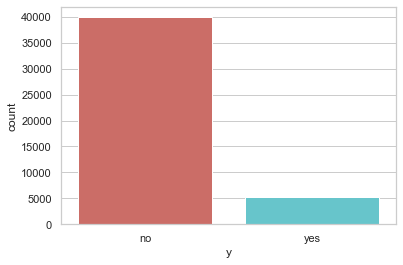

<Figure size 432x288 with 0 Axes>

In [161]:
sns.countplot(x = 'y', data=bank_data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [162]:
count_no_sub = len(bank_data[bank_data['y']=='no'])
count_sub = len(bank_data[bank_data['y']=='yes'])
print("No Subscription Count", count_no_sub)
print("Subscription Count",count_sub)
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription", pct_of_sub*100)

No Subscription Count 39922
Subscription Count 5289
percentage of no subscription is 88.30151954170445
percentage of subscription 11.698480458295547


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 88:12. Before we go ahead to balance the classes, let’s do some more exploration.

In [163]:
bank_data.groupby('y').mean()

,age,balance,day,duration,campaign,pdays,previous
y,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354


#Observations:

* The average age of customers who bought the term deposit is higher than that of the customers who didn’t.

* The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.

* Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.


In [164]:
bank_data.groupby('job').mean()

,age,balance,day,duration,campaign,pdays,previous
job,,,,,,,
admin.,39.289886,1135.838909,15.564301,246.896732,2.575324,47.859021,0.671630
blue-collar,40.044081,1078.826654,15.442561,262.901562,2.816995,44.033498,0.505138
entrepreneur,42.190989,1521.470074,15.702085,256.309348,2.799597,32.486214,0.478144
housemaid,46.415323,1392.395161,16.002419,245.825000,2.820968,21.505645,0.371774
management,40.449567,1763.616832,16.114189,253.995771,2.864348,38.665468,0.668006
retired,61.626767,1984.215106,15.439488,287.361307,2.346731,37.443905,0.638693
self-employed,40.484484,1647.970868,16.027866,268.157061,2.853072,34.747308,0.551615
services,38.740250,997.088108,15.635532,259.318729,2.718344,41.995185,0.501204
student,26.542644,1388.060768,14.897655,246.656716,2.299574,57.041578,0.953092


In [114]:
bank_data.groupby('marital').mean()

,age,balance,day,duration,campaign,pdays,previous
marital,,,,,,,
divorced,45.782984,1178.872287,15.796428,262.517188,2.630882,41.001728,0.551373
married,43.408099,1425.925590,15.854487,253.412765,2.842875,37.950467,0.556552
single,33.703440,1301.497654,15.708210,266.497967,2.649805,44.652385,0.642690


In [165]:
bank_data.groupby('education').mean()

,age,balance,day,duration,campaign,pdays,previous
education,,,,,,,
primary,45.865567,1250.949934,15.421398,255.933002,2.834331,36.081740,0.489272
secondary,39.964270,1154.880786,15.759159,258.685760,2.700802,42.353504,0.567753
tertiary,39.593640,1758.416435,16.086535,258.518532,2.825577,39.024134,0.661980
unknown,44.510501,1526.754443,15.810985,257.313947,2.849219,36.856220,0.488422


# Data Visulization

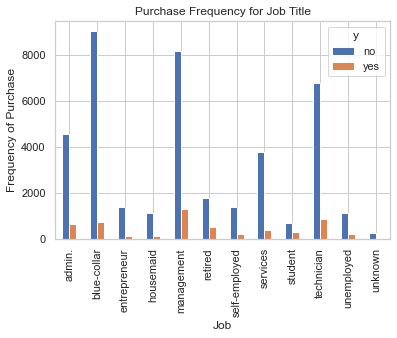

In [166]:
%matplotlib inline
pd.crosstab(bank_data.job,bank_data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

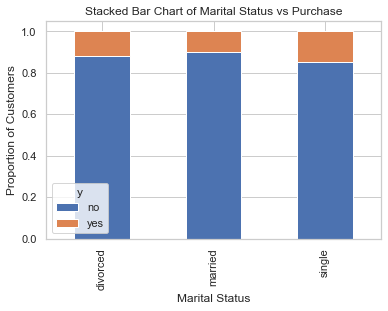

In [167]:
table=pd.crosstab(bank_data.marital,bank_data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

The marital status does not seem a strong predictor for the outcome variable.

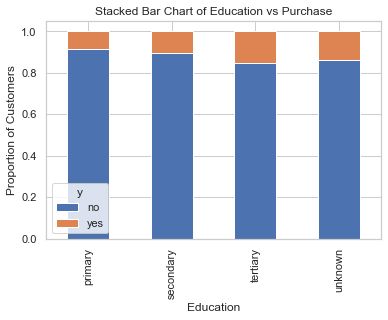

In [168]:
table=pd.crosstab(bank_data.education,bank_data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

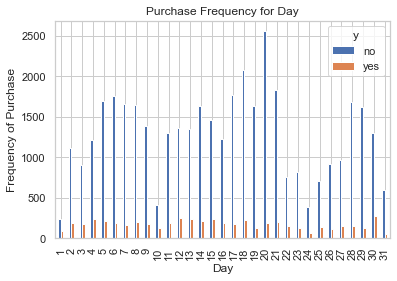

In [169]:
pd.crosstab(bank_data.day,bank_data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day')
plt.xlabel('Day')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_day_bar')

Day may not be a good predictor of the outcome.

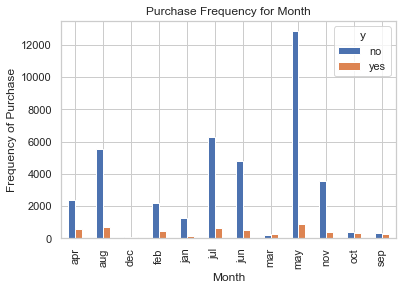

In [170]:
pd.crosstab(bank_data.month,bank_data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable.

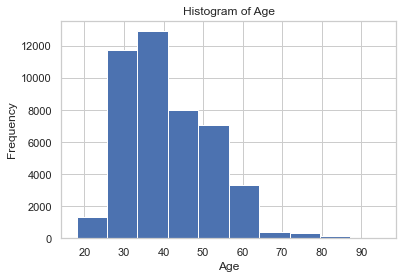

In [171]:
bank_data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the bank in this dataset are in the age range of 30–40.

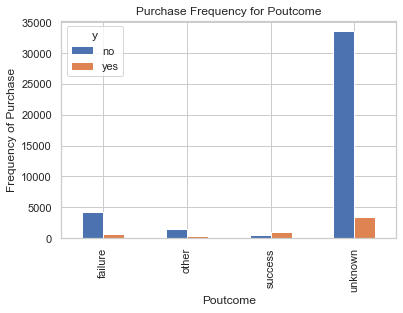

In [122]:
pd.crosstab(bank_data.poutcome,bank_data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

# Create dummy variables

In [172]:
# That is variables with only two values, zero and one.
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bank_data[var], prefix=var)
    data1=bank_data.join(cat_list)
    bank_data=data1
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
data_vars=bank_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [173]:
data_final=bank_data[to_keep]
data_final.columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [175]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

# Feature Selection

In [176]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 18)
rfe = rfe.fit(data_final[X], data_final[y] )
print(rfe.support_)
print(rfe.ranking_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=18 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False  True  True False False False  True False
  True  True  True  True  True False  True  True  True  True  True  True
  True  True  True]
[32 34 31 30 17 33 28 27 19 15  8 24  2 22 21  1 23 10 16 18  4 29  6 20
 11 25 26 12  5  1  1  9  3  7  1 14  1  1  1  1  1 13  1  1  1  1  1  1
  1  1  1]


The Recursive Feature Elimination (RFE) has helped us select the following features: "previous", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'.

In [180]:
cols=[ "previous", "job_blue-collar", "job_retired", "job_services", "job_student", "default_no", 'month_apr', 
      'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 
      'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']
y=data_final[cols]
X=data_final['y']

# Implementing the model

In [183]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# Logistic Regression Model Fitting

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

ValueError: could not convert string to float: 'no'